In [30]:
!pip install tensorflow==2.10.0
!pip install tensorflow-gpu==2.10.0
!pip install tensorflow-datasets==4.8.3
!pip install opencv-python==4.8.1.78
!pip install QKeras==0.9.0
!pip install matplotlib==3.7.2

  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.0 MB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached protobuf-3.19.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl (4.9 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tenso

  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.10.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-gpu 2.10.0 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.


In [31]:
!pip install --upgrade qkeras
!pip install --upgrade keras tensorflow

  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
  Using cached tensorboard-2.15.1-py3-none-any.whl (5.5 MB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl (441 kB)
  Using cached google_auth_oauthlib-1.1.0-py2.py3-none-any.whl (19 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Succes

In [33]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [34]:
!cp "/content/gdrive/My Drive/notmnist_abc.zip" .
!unzip -qq notmnist_abc.zip
!rm notmnist_abc.zip

In [35]:
import keras
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import numpy as np
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import imread
from tensorflow.keras.utils import to_categorical

# **Utils**

In [36]:
def fp_quantize(x, w, f):
    i = w - f
    max = float(2 ** (i - 1) - 2 ** (-f))
    min = float(-2 ** (i - 1))
    n = float(2 ** f)
    xx = np.floor(x * n + 0.5) / n
    clipped = np.clip(xx, a_min=min, a_max=max)
    return clipped

In [37]:
def FPToHex(x, w = 8, f = 7):
    x_fix = x
    x_fix = x_fix * pow(2, f)
    x_fix = int(x_fix)
    if(x_fix < 0):
        binary = bin(x_fix+(1<<w))
    else:
        binary = bin(x_fix)
    return hex(int(binary, 2))[2:]

def WriteFixPToFile(file_name, data_fp, w = 8, f = 7, mode = "w"):
    with open(file_name, mode) as file:
        for i in range(data_fp.shape[0]):
            file.write(str(FPToHex(data_fp[i], w=w, f=f))+'\n')

In [38]:
def twos_complement(bin_num, w, f):
    # Perform 2's complement on the binary number
    flipped = ''
    for bit in bin_num:
        flipped += '0' if bit == '1' else '1'
    comp_num = int(flipped, 2) + 1

    return bin(comp_num)[2:].zfill(len(bin_num))

def fixed_point_to_float(bin_num, w=16, f=14):
        # Check if the number is negative
    sign_bit = int(bin_num[0])
    if sign_bit:
        bin_num = twos_complement(bin_num, w, f)

    # Split the binary number into integer and fractional parts
    if f > 0:
        if f == w:
            float_num = int(bin_num, 2) / 2**f
        else:
            int_part = int(bin_num[:-f], 2)
            frac_part = int(bin_num[-f:], 2) / 2**f
            float_num = int_part + frac_part
    else:
        int_part = int(bin_num, 2)
        float_num = int_part

    # Apply the sign to the floating point number if it was negative
    if sign_bit:
        float_num = -float_num

    return float_num

def hex_to_fixed_point_decimal(hex_value, w, f):
    binary_value = bin(int(hex_value, 16))[2:]

    # # Determine the sign bit
    binary_value = binary_value.zfill(w)

    # return decimal_value
    return fixed_point_to_float(binary_value, w, f)

# **Data Preparation**

In [39]:
LETTERS = {'A': 0, 'B': 1, 'C': 2, 0: 'A', 1: 'B', 2: 'C'}

In [40]:
IMAGE_SIZE = 28

In [41]:
images = np.load("images.npy")
labels = np.load("labels.npy")

In [42]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [43]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [44]:
def resize_images(images, new_size=(28, 28)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

In [45]:
x_train = resize_images(x_train, (IMAGE_SIZE, IMAGE_SIZE))
x_test = resize_images(x_test, (IMAGE_SIZE, IMAGE_SIZE))

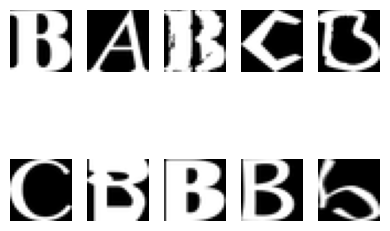

In [46]:
plt.figure(figsize=(4, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [47]:
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(126985, 784)
(31747, 784)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

num_classes = 3

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(IMAGE_SIZE*IMAGE_SIZE,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3969/3969 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9300

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3969/3969 [==============================] - 54s 13ms/step - loss: 0.1735 - accuracy: 0.9300 - val_loss: 0.1370 - val_accuracy: 0.9416
Epoch 2/50
3969/3969 [==============================] - 52s 13ms/step - loss: 0.1338 - accuracy: 0.9446 - val_loss: 0.1232 - val_accuracy: 0.9484
Epoch 3/50
3969/3969 [==============================] - 51s 13ms/step - loss: 0.1189 - accuracy: 0.9499 - val_loss: 0.1177 - val_accuracy: 0.9500
Epoch 4/50
3969/3969 [==============================] - 54s 14ms/step - loss: 0.1068 - accuracy: 0.9548 - val_loss: 0.1196 - val_accuracy: 0.9508
Epoch 5/50
3969/3969 [==============================] - 54s 14ms/step - loss: 0.0989

In [ ]:
from sklearn.metrics import classification_report
import numpy as np


predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
report = classification_report(true_classes, predicted_classes, target_names=['A', 'B', 'C'])

print(report)

In [ ]:
def calculate_model_size(layers_neurons, bit_per_weight):
    total_weights = 0
    for i in range(1, len(layers_neurons)):
        layer_weights = (layers_neurons[i-1] + 1) * layers_neurons[i]
        total_weights += layer_weights

    total_size_bytes = total_weights * bit_per_weight / 8
    total_size_kb = total_size_bytes / 1024

    return total_size_kb

layers_neurons = [IMAGE_SIZE*IMAGE_SIZE, 512, 256, 128, 3]
model_size_kb = calculate_model_size(layers_neurons, 32)
print("Estimated model size: {:.2f} KB".format(model_size_kb))


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2

def resize_images(images, new_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

new_image_size = (16, 16)
x_train_resized = resize_images(x_train, new_image_size)
x_test_resized = resize_images(x_test, new_image_size)

x_train_flat = x_train_resized.reshape((len(x_train_resized), np.prod(x_train_resized.shape[1:])))
x_test_flat = x_test_resized.reshape((len(x_test_resized), np.prod(x_test_resized.shape[1:])))

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(np.prod(new_image_size),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 کلاس

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(x_train_flat, y_train, batch_size=32, epochs=30, validation_data=(x_test_flat, y_test))


score = model.evaluate(x_test_flat, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
import matplotlib.pyplot as plt

for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        plt.hist(weights[0].flatten(), bins=50)
        plt.title(f"Histogram of weights for layer: {layer.name}")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.show()


In [ ]:
from qkeras import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(QDense(128, input_dim=np.prod(new_image_size),
                 kernel_quantizer=quantized_bits(8),
                 bias_quantizer=quantized_bits(8),
                 activation='relu'))
model.add(QDense(64, kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8)))
model.add(QActivation(quantized_relu(8)))
model.add(QDense(3, kernel_quantizer=quantized_bits(8), bias_quantizer=quantized_bits(8), activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train_flat, y_train, batch_size=32, epochs=30, validation_data=(x_test_flat, y_test))

score = model.evaluate(x_test_flat, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
import numpy as np


quantized_inputs = np.round(x_test_input * 255).astype(np.uint8)
np.savetxt('inputs.mem', quantized_inputs, fmt='%d', delimiter='\n')

for i, layer in enumerate(model.layers):
    weights = layer.get_weights()
    if len(weights) > 0:
        quantized_weights_8bit = np.round(weights[0] * 255).astype(np.uint8)
        quantized_weights_6bit = np.round(weights[0] * 63).astype(np.uint8)

        np.savetxt(f'weights_layer_{i}_8bit.mem', quantized_weights_8bit, fmt='%d', delimiter='\n')
        np.savetxt(f'weights_layer_{i}_6bit.mem', quantized_weights_6bit, fmt='%d', delimiter='\n')

if x_test_input.shape[1] > 100:
    first_layer_output = model.layers[0](x_test_input).numpy()
    np.savetxt('first_layer_output.txt', first_layer_output, fmt='%f', delimiter='\n')


# **Save Weights as Fixed Point**

In [49]:
y1 = None #replace it with the output of the first layer (after its activation layer)

In [50]:
WriteFixPToFile("input.txt", y1[0][0], 9, 7)

TypeError: ignored

In [ ]:
if not os.path.exists('weights'):
    os.mkdir('weights')

In [ ]:
count = 0
for layer in model.layers:
    weights = layer.get_weights()
    if weights and len(weights) > 0:
        count += 1
        w_per_neuron = weights[0].shape[0]
        w = np.array(layer.kernel_quantizer(weights[0])).transpose().reshape(-1,)
        b = np.array(layer.kernel_quantizer(weights[1])).reshape(-1,)
        separate_weights = [np.concatenate((w[c:c+w_per_neuron], b[int(c/w_per_neuron):int(c/w_per_neuron)+1]), axis=0) for c in range(0, len(w), w_per_neuron)]

        #pay attention to this part
        width, f = (17, 14) if layer.name == 'last' else (9, 7) #pay attention to this part
        for n, s in enumerate(separate_weights):
            WriteFixPToFile(f"weights/layer_{count}_{n + 1}_w.mem", s, width, f)

##############################################################################